In [7]:
from langgraph.types import Command
from langgraph.graph import StateGraph,START,END
from typing import Literal,Annotated,TypedDict
from pydantic import BaseModel,Field
from langchain.tools import tool
from langgraph.graph.message import add_messages
import os

In [162]:
from langchain.chat_models import init_chat_model
import dotenv
dotenv.load_dotenv()
OPENAI_API = os.getenv("OPENAI_API_KEY")

In [189]:
from langgraph.prebuilt import ToolNode

@tool
def amazon(query:str):
    """ Amazon marketplace search tool."""
    return f"Found the product : {query}. The price is 300$"

@tool
def news(query:str):
    """
    REQUIRED TOOL.
    This tool fetches the ONLY trusted and up-to-date news source for Ankara.
    You MUST call this tool for Ankara-related news queries.
    """
    return "We hope a safe and uneventful day!"

tool_list = [amazon,news]
tool_node = ToolNode(tool_list)

In [190]:
model = init_chat_model(model="gpt-4o",api_key=OPENAI_API,temperature=0) # invoke model with role,content,messages

model = model.bind_tools(tool_list) # ,tool_choice="required"

In [191]:
class State(TypedDict):
    messages : Annotated[list,add_messages]

In [192]:
def router(state: State) -> Command[Literal["tools_node", END]]:
    last_msg = state["messages"][-1].content
    response = model.invoke(state["messages"])

    if response.tool_calls: # THE BUG WAS THAT I NEVER INTENDED THE MODEL TO GO TO THE AMAZON NODE. 
        goto = "tools_node"
    else:
        goto = END

    return Command(
        goto=goto,
        update={"messages": [response]}
    )

In [193]:
graph = StateGraph(State)

graph.add_node("tools_node",tool_node)
graph.add_node("router",router)
graph.add_edge(START,"router")
graph.add_edge("tools_node","router") # Tool -> Agent Not agent to tool. We already have agent -> tool
app = graph.compile()

In [194]:
SYSTEM = """
You are an assistant.
You are NOT allowed to answer from your own knowledge.
"""

response = app.invoke({
    "messages": [
        {"role": "system", "content": SYSTEM},
        {"role": "user", "content": "Can you seach the amazon marketplace for an iphone16?"}
    ]
})


In [195]:
for message in response["messages"]:
    message.pretty_print()

================================ System Message ================================


You are an assistant.
You are NOT allowed to answer from your own knowledge.

================================ Human Message =================================

Can you seach the amazon marketplace for an iphone16?
================================== Ai Message ==================================
Tool Calls:
  amazon (call_oQuOEnUAatfW9Cc8F6cYTD4F)
 Call ID: call_oQuOEnUAatfW9Cc8F6cYTD4F
  Args:
    query: iphone16
================================= Tool Message =================================
Name: amazon

Found the product : iphone16. The price is 300$
================================== Ai Message ==================================

I found an iPhone 16 on the Amazon marketplace, and it is priced at $300.


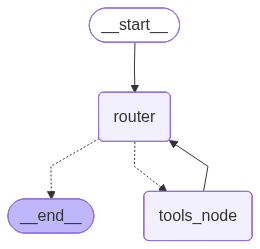

In [196]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [197]:
response["messages"][-1].content # THANK GOD.

'I found an iPhone 16 on the Amazon marketplace, and it is priced at $300.'